# Transit routing 

Finally, let's see how it is possible to do routing with public transport in Python. 

We will again follow more or less the same steps as described previously:

 1. **Retrieve data** 
      1. (Modify the network) - not done in here
 3. **Build a routable graph** for NetworkX 
 4. **Conduct network analysis**

## 1. Retrieve data

When routing with public transport it is necessary to merge data from different sources. For walking legs, typically routing tools use OpenStreetMap data, and for public transport data, routing engines use so called [GTFS](https://developers.google.com/transit/gtfs/reference) data, which is an international standard for publishing transit information (schedules, stops, routes, effective dates, etc.). 

For public transport routing we are going to use a few different libraries:

 - [urbanaccess](https://udst.github.io/urbanaccess/introduction.html) is used to create the transit graph from GTFS data and OSM data
 - [osmnx](https://osmnx.readthedocs.io/en/stable/) is used to fetch the walking network
 - [ua2nx](https://github.com/HTenkanen/ua2nx) is used to convert the UrbanAccess graph into NetworkX graph.

### GTFS basics

GTFS - General Transit Feed Specification - data is structured in a following manner:

![gtfs_schema](img/GTFS_schema.PNG)

As we can see, the dataset is distributed into various different tables that all have a different function. We won't spend too much time for going through the details about the GTFS dataset, but it's good to understand few basic things:
 
 - `stops.txt`, includes information about stops (they are the **nodes** in the transit network)
 - `stop_times.txt`, includes information about departure and arrival time for each stop at different times of the day (this is the table that is central for generating the **edges** in the transit network.
 - `trips.txt` includes information about trips (a single trip typically starts at specific time of the day from given route origin)
 - `routes.txt` includes information about routes (such as line-codes or what transport mode a given route is)

### Data sources for GTFS data

GTFS data is published and provided by transportation authorities across the world. There are a couple of good websites where you can find transit data for thousands of cities across the world:

 - [transitfeeds.com](https://transitfeeds.com/)
 - [transit.land](http://transit.land/)
  
You later on test to download data from other cities, but in this tutorial **we will use GTFS data from Kotka, Finland.** GTFS data is distributed in zip-files containing various text-files. 

The repository contains a folder [data/kotka](data/kotka) which contains all the text-files associated with the given GTFS dataset.  

- Let's start by reading the GTFS data with the urbanaccess library. 

In [1]:
import urbanaccess as ua
import ua2nx 
import osmnx as ox
import networkx as nx
import geopandas as gpd
%matplotlib inline

# File path to GTFS files (unzipped) - needs to be a full path (relative path does not work, an issue in urbanaccess)
#gtfs_dir = "data/kotka"
gtfs_dir = "/mnt/c/HY-DATA/hentenka/KOODIT/Uni/routing-workshop/docs/data/kotka"

# A bounding box can be used to limit the area where the data is kept for the graph
# Let's limit the data in any way that it covers the Kotka region
bbox = (26.5, 60.3, 27.5, 60.9)

# Load feed 
loaded_feed = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path=gtfs_dir,
                                              validation=True,
                                              verbose=False,
                                              bbox=bbox,
                                              remove_stops_outsidebbox=True,
                                              append_definitions=True)   

# What is the loaded_feed?
type(loaded_feed)

GTFS text file header whitespace check completed. Took 0.07 seconds
--------------------------------
Processing GTFS feed: kotka
GTFS feed: kotka, calendar_dates uses the same service_id across multiple agency_ids. This feed calendar_dates table will be modified from its original format to provide service_ids for each agency using a one to many join
GTFS feed: kotka, calendar uses the same service_id across multiple agency_ids. This feed calendar table will be modified from its original format to provide service_ids for each agency using a one to many join
GTFS feed: kotka, stops uses the same stop_id across multiple agency_ids. This feed stops table will be modified from its original format to provide stop_ids for each agency using a one to many join
agency.txt agency_name column has more than one agency name listed. Unique agency id was assigned using the agency id and associated agency name.
Unique agency id operation complete. Took 0.88 seconds
Unique GTFS feed id operation complet

urbanaccess.gtfs.gtfsfeeds_dataframe.urbanaccess_gtfs_df

Okay, now we have loaded the GTFS dataset into a variable `loaded_feed`. As we can see the loaded_feed is a specific urbanaccess_gtfs_df -object that basically contains all necessary GTFS information as separate DataFrames.

- Let's explore the data what we have:

In [2]:
# Get different GTFS data into DataFrames
stops = loaded_feed.stops
trips = loaded_feed.trips
stop_times = loaded_feed.stop_times
routes = loaded_feed.routes

# Print 
stops.head(1)

,stop_id,unique_agency_id,stop_code,stop_name,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,municipality_id,stop_desc,stop_timezone,wheelchair_boarding,platform_code,vehicle_type,unique_feed_id,route_type,location_type_desc,wheelchair_boarding_desc
0,127573,jyrkilä_oy,NaN,Vastilantie 1664,60.61632,26.646239,1,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,kotka_1,3.0,stop,No accessibility information available for the...


In [3]:
trips.head(1)

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,bikes_allowed,trip_short_name,wheelchair_accessible,unique_agency_id,unique_feed_id,bikes_allowed_desc,wheelchair_accessible_desc
0,2,Koulup. Kotka,1088983a-667d-4f7c-be24-e3027825f7c8,NaN,1,NaN,90,0,NaN,0,oy_pohjolan_liikenne_ab,kotka_1,None,None


In [4]:
routes.head(1)

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,bikes_allowed,unique_agency_id,unique_feed_id,route_type_desc
0,1,6852,1,1 Kotka-Hamina,NaN,3,NaN,NaN,NaN,NaN,oy_pohjolan_liikenne_ab,kotka_1,Bus


In [5]:
stop_times.head(5)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,shape_dist_traveled,timepoint,stop_headsign,pickup_type,drop_off_type,unique_agency_id,unique_feed_id,route_type,pickup_type_desc,drop_off_type_desc,timepoint_desc,departure_time_sec
0,1088983a-667d-4f7c-be24-e3027825f7c8,07:15:00,07:15:00,134895,1,NaN,0,NaN,0,0,oy_pohjolan_liikenne_ab,kotka_1,3,Regularly Scheduled,Regularly Scheduled,Approximate times,26100
1,1088983a-667d-4f7c-be24-e3027825f7c8,07:16:00,07:16:00,134892,2,NaN,0,NaN,0,0,oy_pohjolan_liikenne_ab,kotka_1,3,Regularly Scheduled,Regularly Scheduled,Approximate times,26160
2,1088983a-667d-4f7c-be24-e3027825f7c8,07:16:00,07:16:00,134890,3,NaN,0,NaN,0,0,oy_pohjolan_liikenne_ab,kotka_1,3,Regularly Scheduled,Regularly Scheduled,Approximate times,26160
3,1088983a-667d-4f7c-be24-e3027825f7c8,07:16:00,07:16:00,134888,4,NaN,0,NaN,0,0,oy_pohjolan_liikenne_ab,kotka_1,3,Regularly Scheduled,Regularly Scheduled,Approximate times,26160
4,1088983a-667d-4f7c-be24-e3027825f7c8,07:18:00,07:18:00,134886,5,NaN,0,NaN,0,0,oy_pohjolan_liikenne_ab,kotka_1,3,Regularly Scheduled,Regularly Scheduled,Approximate times,26280


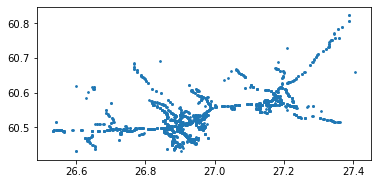

In [6]:
# Make a GeoDataFrame from stops
stops['geometry'] = gpd.points_from_xy(stops['stop_lon'], stops['stop_lat'])
stops = gpd.GeoDataFrame(stops)

# Plot 
stops.plot(markersize=3)

Okay, as we can see there exist quite a few stops in the Kotka region. 

Let's next retrieve the walking network with OSMnx. We use OSMnx to fetch the data so that we get a full walking network from the same area where the transit data is located. 

- Let's first define a function to retrieve OSM walk network data and format in a way as urbanaccess wants it:

In [7]:
def get_osmnx_walk_network(bbox):
    # Download OSM data with OSMnx from the same area where the GTFS data is taken from
    G = ox.graph_from_polygon(polygon=bbox, network_type='walk')
    walk_nodes, walk_edges = ox.graph_to_gdfs(G)
    
    # Rename edges in UrbanAccess style
    walk_edges = walk_edges.rename(columns={'u': 'from', 'v':'to', 'length': 'distance'})
    walk_edges = walk_edges.drop('osmid', axis=1)
    
    # Give index (sequential number) for the walk nodes as urban access uses those as keys
    walk_nodes = walk_nodes.reset_index(drop=True)
    walk_nodes['id'] = walk_nodes.index
    walk_nodes = walk_nodes.set_index('id', drop=False)
    
    # Convert from/to values to integers according nodes
    walk_edges = walk_edges.merge(walk_nodes[['osmid', 'id']], left_on='from', right_on='osmid').rename(columns={'id':'from_int'}).drop('osmid', axis=1)
    walk_edges = walk_edges.merge(walk_nodes[['osmid', 'id']], left_on='to', right_on='osmid').rename(columns={'id':'to_int'}).drop('osmid', axis=1)
    walk_edges['from_osm'] = walk_edges['from']
    walk_edges['to_osm'] = walk_edges['to']
    walk_edges['from'] = walk_edges['from_int']
    walk_edges['to'] = walk_edges['to_int']
    walk_edges = walk_edges.drop(['from_int', 'to_int'], axis=1)
    return (walk_nodes, walk_edges)

Now, we can use the function to retrieve the data using the minimum bounding box around the stops.

In [8]:
from shapely.geometry import box
# Get the bounds of the stops for retrieving the walking network
bbox = box(*stops.geometry.total_bounds)

# Get the walk nodes and edges
walk_nodes, walk_edges = get_osmnx_walk_network(bbox)

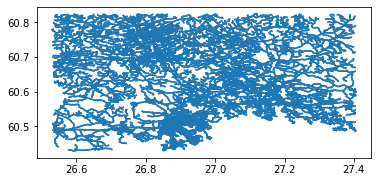

In [9]:
# Let's see what we have
walk_edges.plot()

In [10]:
# Edge attributes
walk_edges.head(2)

,from,to,key,name,highway,service,oneway,distance,geometry,ref,lanes,maxspeed,bridge,access,width,tunnel,junction,area,from_osm,to_osm
0,0,22736,0,Yrjöntie,service,driveway,False,11.469,"LINESTRING (26.80853 60.78053, 26.80863 60.78062)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2692481025,2692480923
1,7890,22736,0,Yrjöntie,service,driveway,False,3.549,"LINESTRING (26.80867 60.78065, 26.80863 60.78062)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1930122120,2692480923


From here the most important attributes are `from`, `to` and `distance` columns that are used for building the routable graph (walking legs). 

## 2. Build the multimodal transit graph

Next, we will build a routable graph from the GTFS data and OSM data that we loaded in the previous step.

Let's first build the transit net. When building the transit net, we need to specify which departure times should be included in the graph. A good practice is to select certain hour such as data between `07:00:00` and `08:00:00`. The travel costs for edges will be aggregated using all possible PT connections that are operating between those times. We also need to specify the weekday when the routing happens, e.g. `thursday`.

In [11]:
# Let specify the parameters for our graph
time_range = ['07:00:00', '08:00:00']
weekday = 'thursday'

# Build a transit network based on GTFS
ua.gtfs.network.create_transit_net(gtfsfeeds_dfs=loaded_feed,
                                   day=weekday,
                                   timerange=time_range
                                   )

Using calendar to extract service_ids to select trips.
33 service_ids were extracted from calendar
752 trip(s) 44.84 percent of 1,677 total trip records were found in calendar for GTFS feed(s): ['kotka']
NOTE: If you expected more trips to have been extracted and your GTFS feed(s) have a calendar_dates file, consider utilizing the calendar_dates_lookup parameter in order to add additional trips based on information inside of calendar_dates. This should only be done if you know the corresponding GTFS feed is using calendar_dates instead of calendar to specify service_ids. When in doubt do not use the calendar_dates_lookup parameter.
752 of 1,677 total trips were extracted representing calendar day: thursday. Took 0.03 seconds
There are no departure time records missing from trips following thursday schedule. There are no records to interpolate.
Difference between stop times has been successfully calculated. Took 0.15 seconds
Stop times from 07:00:00 to 08:00:00 successfully selected 2,1

Great! Now we have built a transit network which will use shortly. 

- Next, let's build the walking network. For walking, we need to specify the walking speed (4.5 kmph in miles per hour).


In [12]:
def kmph_to_mph(kmph):
    """Converts km per hour into miles per hour."""
    return kmph / 1.609344

# Build the walking graph with walking speed 4.5 kmph
walk_speed = 4.5
ua.osm.network.create_osm_net(osm_edges=walk_edges,
                              osm_nodes=walk_nodes,
                              travel_speed_mph=kmph_to_mph(walk_speed))

Created OSM network with travel time impedance using a travel speed of 2.7961703650680025 MPH. Took 0.00 seconds


Great! Now we have built both the walking network and PT network. 

Next, we need to do a special trick by **adding headways** for stops/stations. This means that when routing, additional time will be spent in stops when e.g. changing from vehicle to another. The headway times are calculated based on the transit schedules. 

In [13]:
# Add headways (average wait times at stops/stations)
ua.gtfs.headways.headways(gtfsfeeds_df=loaded_feed,
                          headway_timerange=time_range)

Stop times from 07:00:00 to 08:00:00 successfully selected 2,106 records out of 25,100 total records (8.39 percent of total). Took 0.01 seconds
Starting route stop headway calculation for 1,315 route stops...
Route stop headway calculation complete. Took 3.54 seconds
headway calculation complete. Took 3.71 seconds


Finally, we need to connect the walking and PT networks together. As a result, we have a multimodal network where it is possible to either walk or travel with PT between given locations (the faster mode will be used). 

- Let's integrate the networks together

In [14]:
# Connect walk and PT networks
ua.network.integrate_network(urbanaccess_network=ua.gtfs.network.ua_network,
                             headways=True,
                             urbanaccess_gtfsfeeds_df=loaded_feed,
                             headway_statistic='mean')


Loaded UrbanAccess network components comprised of:
     Transit: 896 nodes and 2,016 edges;
     OSM: 22,776 nodes and 55,752 edges
routes successfully joined to transit nodes. Took 0.02 seconds
Connector edges between the OSM and transit network nodes successfully completed. Took 0.38 seconds
mean route stop headway will be used for pedestrian to transit edge impedance.
Headway impedance calculation completed. Took 0.01 seconds
Edge and node tables formatted for Pandana with integer node ids: id_int, to_int, and from_int. Took 2.76 seconds
Network edge and node network integration completed successfully resulting in a total of 24,091 nodes and 61,189 edges:
     Transit: 1,315 nodes 2,016 edges;
     OSM: 22,776 nodes 55,752 edges; and
     OSM/Transit connector: 3,421 edges.


Great! Now we have built a routable `urbanaccess_network` that can be used with [Pandana](http://udst.github.io/pandana/). For basic routing purposes Pandana, however, is not very suitable library. Hence, we need to first convert the UrbanAccess network into NetworkX graph, so that we can use it in a similar manner as in the previous routing examples.

Converting UrbanAccess graph into a directed NetworkX graph is easy with a dedicated tool called [ua2nx](https://github.com/HTenkanen/ua2nx) (developed/maintained by Henkka). During the conversion, the ua2nx will optimize graph and aggregate the travel times with selected aggregation method (possible options are: min, max, mean, median). This is a bit similar thing as "forking" (haarukointi) with MetropAccess-Reititin using Golomb ruler. 

In [15]:
# Get the UrbanAccess graph
uaG = ua.network.ua_network

# Convert it into NetworkX using `median` as the optimization method 
# (`min` would mean that the absolutely fastest travel times would be used)
optimization_method='mean'
G = ua2nx.urbanaccess_to_nx(uaG, optimize=optimization_method, weight_col='weight')

Converting to NetworkX graph ..
Converted nodes in 0.2 minutes.
Converted edges in 0.6 minutes.
Created NetworkX graph in 0.8 minutes with 24091 nodes and 58497 edges.


That's it! Now we can check how our graph looks like by using the "traditional" OSMnx methods.

- Let's plot our graph

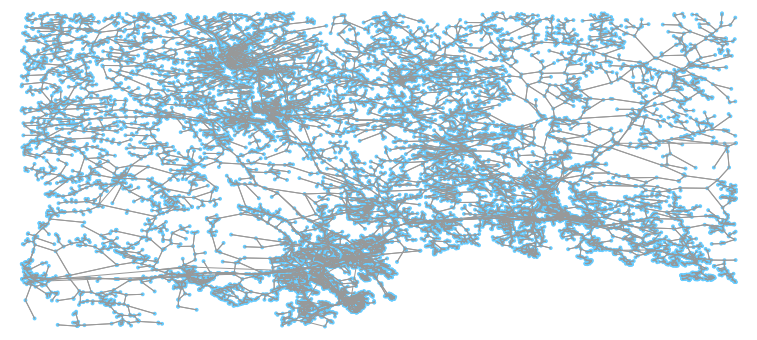

In [16]:
fig, ax = ox.plot_graph(G)

As we can see, the graph looks quite messy, but if looking closely we can see longer edges in the figure. Those are the transit lines (buses in this case). 

- Let's take a closer look at the edge attributes:

In [17]:
# Convert graph to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G)

# What do we have?
edges.head(10)

,u,v,key,from,to,from_int,to_int,weight,net_type,route_type,sequence,unique_agency_id,unique_route_id,unique_trip_id,geometry
0,1,2,0,309926_jyrkilä_oy_3009_jyrkilä_oy,133832_jyrkilä_oy_3009_jyrkilä_oy,1,2,1.000000,transit,3.0,1.0,jyrkilä_oy,3009_jyrkilä_oy,04b08223-9e96-41b1-8b50-c6a233bde3dd_jyrkilä_oy,"LINESTRING (26.97336 60.56239, 26.98236 60.56828)"
1,1,27,1,309926_jyrkilä_oy_3009_jyrkilä_oy,302374_jyrkilä_oy_3009_jyrkilä_oy,1,27,4.000000,transit,3.0,27.0,jyrkilä_oy,3009_jyrkilä_oy,04b08223-9e96-41b1-8b50-c6a233bde3dd_jyrkilä_oy,"LINESTRING (26.97336 60.56239, 26.97471 60.54139)"
2,1,5033,2,309926_jyrkilä_oy_3009_jyrkilä_oy,3717,1,5033,0.550328,transit to osm,NaN,NaN,nan,nan,nan,"LINESTRING (26.97336 60.56239, 26.97351 60.56200)"
3,2,3,3,133832_jyrkilä_oy_3009_jyrkilä_oy,133834_jyrkilä_oy_3009_jyrkilä_oy,2,3,0.000000,transit,3.0,2.0,jyrkilä_oy,3009_jyrkilä_oy,04b08223-9e96-41b1-8b50-c6a233bde3dd_jyrkilä_oy,"LINESTRING (26.98236 60.56828, 26.97981 60.57071)"
4,2,6131,4,133832_jyrkilä_oy_3009_jyrkilä_oy,4815,2,6131,0.554874,transit to osm,NaN,NaN,nan,nan,nan,"LINESTRING (26.98236 60.56828, 26.98283 60.56795)"
5,3,4,5,133834_jyrkilä_oy_3009_jyrkilä_oy,133835_jyrkilä_oy_3009_jyrkilä_oy,3,4,1.000000,transit,3.0,3.0,jyrkilä_oy,3009_jyrkilä_oy,04b08223-9e96-41b1-8b50-c6a233bde3dd_jyrkilä_oy,"LINESTRING (26.97981 60.57071, 26.97765 60.57430)"
6,3,11895,6,133834_jyrkilä_oy_3009_jyrkilä_oy,10579,3,11895,0.508952,transit to osm,NaN,NaN,nan,nan,nan,"LINESTRING (26.97981 60.57071, 26.98006 60.57036)"
7,4,5,7,133835_jyrkilä_oy_3009_jyrkilä_oy,133837_jyrkilä_oy_3009_jyrkilä_oy,4,5,1.000000,transit,3.0,4.0,jyrkilä_oy,3009_jyrkilä_oy,04b08223-9e96-41b1-8b50-c6a233bde3dd_jyrkilä_oy,"LINESTRING (26.97765 60.57430, 26.97667 60.57979)"
8,4,6491,8,133835_jyrkilä_oy_3009_jyrkilä_oy,5175,4,6491,0.305192,transit to osm,NaN,NaN,nan,nan,nan,"LINESTRING (26.97765 60.57430, 26.97757 60.57452)"
9,5,6,9,133837_jyrkilä_oy_3009_jyrkilä_oy,304449_jyrkilä_oy_3009_jyrkilä_oy,5,6,1.000000,transit,3.0,5.0,jyrkilä_oy,3009_jyrkilä_oy,04b08223-9e96-41b1-8b50-c6a233bde3dd_jyrkilä_oy,"LINESTRING (26.97667 60.57979, 26.97286 60.58495)"


Okay, we have plenty of interesting information here. Some of the useful attributes in the data:

 - `weight`, the cost attribute in the graph (travel time in minutes)
 - `net_type`, tells whether a given edge is i) a transit edge, ii) a walking edge, or iii) a connector edge (connects the networks together)
 - `route_type`, tells which transport mode the given edge is (e.g. here it's number 3 which means bus, see [more info here](https://developers.google.com/transit/gtfs/reference#routestxt)) 

## 3. Routing with public transport

Now as our data is in the same format as in our previous examples...yes...we can do the routing following more or less the same logic as before!

- Let's conduct an example routing between two locations in Kotka to demonstrate that our tools work:

In [18]:
# Addresses
orig_address = "Koulukatu 6, Kotka, Finland"
orig_y, orig_x = ox.geocode(orig_address)  # notice the coordinate order (y, x)!

dest_address = "Peurantie 22, Kotka, Finland"
dest_y, dest_x = ox.geocode(dest_address)

In [19]:
# 1. Find the closest nodes for origin and destination
orig_node_id, dist_to_orig = ox.get_nearest_node(G, point=(orig_y, orig_x), method='haversine', return_dist=True)
dest_node_id, dist_to_dest = ox.get_nearest_node(G, point=(dest_y, dest_x), method='haversine', return_dist=True)

In [20]:
# 2. Calculate the shortest path by transit 
transit_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='weight')

# Get also the actual travel time (summarize)
transit_t = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='weight')

In [21]:
# 3. Plot the results
# -------------------
def node_list_to_coordinate_lines(G, node_list, use_geom=True, weight_col='length'):
    """Obtained from OSMnx with custom weight_col."""
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    for u, v in edge_nodes:
        # if there are parallel edges, select the shortest in length
        data = min(G.get_edge_data(u, v).values(), key=lambda x: x[weight_col])

        # if it has a geometry attribute (ie, a list of line segments)
        if 'geometry' in data and use_geom:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute, the edge is a straight
            # line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
    return lines

def plot_graph_route(G, route, weight_col='length', bbox=None, fig_height=6, fig_width=None,
                     margin=0.02, bgcolor='w', axis_off=True, show=True,
                     save=False, close=True, file_format='png', filename='temp',
                     dpi=300, annotate=False, node_color='#999999',
                     node_size=15, node_alpha=1, node_edgecolor='none',
                     node_zorder=1, edge_color='#999999', edge_linewidth=1,
                     edge_alpha=1, use_geom=True, origin_point=None,
                     destination_point=None, route_color='r', route_linewidth=4,
                     route_alpha=0.5, orig_dest_node_alpha=0.5,
                     orig_dest_node_size=100, orig_dest_node_color='r',
                     orig_dest_point_color='b'):
    """
    Modified from OSMnx with custom weight_col, see: 
    """
    from matplotlib.collections import LineCollection

    # plot the graph but not the route
    fig, ax = ox.plot_graph(G, bbox=bbox, fig_height=fig_height, fig_width=fig_width,
                         margin=margin, axis_off=axis_off, bgcolor=bgcolor,
                         show=False, save=False, close=False, filename=filename,
                         dpi=dpi, annotate=annotate, node_color=node_color,
                         node_size=node_size, node_alpha=node_alpha,
                         node_edgecolor=node_edgecolor, node_zorder=node_zorder,
                         edge_color=edge_color, edge_linewidth=edge_linewidth,
                         edge_alpha=edge_alpha, use_geom=use_geom)

    # the origin and destination nodes are the first and last nodes in the route
    origin_node = route[0]
    destination_node = route[-1]

    if origin_point is None or destination_point is None:
        # if caller didn't pass points, use the first and last node in route as
        # origin/destination
        origin_destination_lats = (G.nodes[origin_node]['y'], G.nodes[destination_node]['y'])
        origin_destination_lons = (G.nodes[origin_node]['x'], G.nodes[destination_node]['x'])
    else:
        # otherwise, use the passed points as origin/destination
        origin_destination_lats = (origin_point[0], destination_point[0])
        origin_destination_lons = (origin_point[1], destination_point[1])
        orig_dest_node_color = orig_dest_point_color

    # scatter the origin and destination points
    ax.scatter(origin_destination_lons, origin_destination_lats, s=orig_dest_node_size,
               c=orig_dest_node_color, alpha=orig_dest_node_alpha, edgecolor=node_edgecolor, zorder=4)

    # plot the route lines
    lines = node_list_to_coordinate_lines(G, route, use_geom, weight_col)

    # add the lines to the axis as a linecollection
    lc = LineCollection(lines, colors=route_color, linewidths=route_linewidth, alpha=route_alpha, zorder=3)
    ax.add_collection(lc)

    # save and show the figure as specified
    fig, ax = ox.save_and_show(fig, ax, save, show, close, filename, file_format, dpi, axis_off)
    return fig, ax

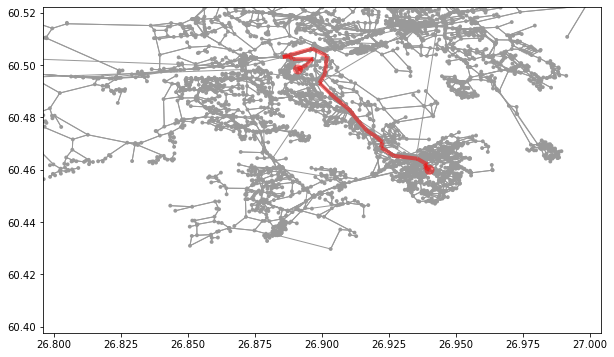

Text(0.5, 3.200000000000003, 'Travel time by transit  17.8 minutes.')

In [22]:
# Let's plot our path with the custom functions
# Visualize static map
fig, ax = plot_graph_route(G, transit_path, weight_col='weight', axis_off=False, bbox=(60.52, 60.4, 27.0, 26.8))

# Add the travel time as title
ax.set_xlabel("Travel time by transit {t: .1f} minutes.".format(t=transit_t))

And voilá! Now we have succesfully routed a trip by public transport in Kotka from one location to another. 

Checking the same trip with Google Maps shows that our time estimate tends to be slightly optimistic: 

![Google Maps ref](img/Google_maps_reference.PNG)

One reason for the difference in travel time, is that we did not yet consider the walking time from origin and destination nodes to the closest network nodes:


In [23]:
# Add time for walking from door to closest node
orig_additional_t = dist_to_orig / 75  # 75 meters per minute is 4.5 kmph
dest_additional_t = dist_to_dest / 75
add_t = orig_additional_t + dest_additional_t

# New time
new_tot_time = transit_t + add_t
print("New total time:", new_tot_time)

New total time: 19.395666462133924


Okay, we are getting closer! Now the difference between Google's answer and ours is ~1.5 minutes. This difference might happen due to slightly different schedule data as the data in our example is from April 2019, whereas the Google's estimate is from January 9th 2020. 